Preparation

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os
from datetime import datetime

%matplotlib inline

In [50]:
RESULTS_PATH = "../results"
plt.rcParams['figure.dpi'] = 100

In [51]:
pattern = RESULTS_PATH+"/*.json"
json_files = glob.glob(pattern)
data = []
for file in json_files:
  with open(file, "r") as json_file:
    json_data = json.load(json_file)
    data.append(json_data)
df = pd.json_normalize(data)

In [52]:
benchmark_implementation_info = []
filtered_data = [project for project in data if project and project.get("BenchmarkData", {}) and project.get("BenchmarkData", {}).get("benchmarkCount", 0) > 0]
for project_data in filtered_data:
  project_created_at = datetime.strptime(project_data["GitRepo"]["created_at"], "%Y-%m-%dT%H:%M:%SZ")
  benchmark_suites = []
  if "suites" in project_data["BenchmarkData"]:
    benchmark_suites = project_data["BenchmarkData"]["suites"]
  for suite in benchmark_suites:
    benchmark_modifications = []
    if "benchmarkModificationInfo" in suite and suite["benchmarkModificationInfo"] != None:
      benchmark_modifications = suite["benchmarkModificationInfo"]
    for benchmark_info in benchmark_modifications:
      if benchmark_info["createdOn"] == "n/a" or benchmark_info["lastUpdateOn"] == "n/a":
        continue
      benchmark_created_on = datetime.strptime(benchmark_info["createdOn"], "%Y-%m-%d")
      benchmark_last_modification = datetime.strptime(benchmark_info["lastUpdateOn"], "%Y-%m-%d")
      modification_difference = (benchmark_last_modification - benchmark_created_on).days
      creation_difference = (benchmark_created_on - project_created_at).days
      number_of_modifications = benchmark_info["modificationCount"] - 1

      benchmark_implementation_info.append({"daysSinceBirth": creation_difference, "daysFromImplementationToModification": modification_difference, "modificationsCount": number_of_modifications, "count": 1})

benchmarks_df = pd.DataFrame(benchmark_implementation_info)
benchmarks_df = benchmarks_df[(benchmarks_df["daysSinceBirth"] >= 0) & (benchmarks_df["daysFromImplementationToModification"] >= 0)]


In [53]:
benchmarks_count = 0
for project_data in filtered_data:
  benchmarks_count = benchmarks_count + project_data.get("BenchmarkData", {}).get("benchmarkCount", 0)
benchmarks_count

78983

In [54]:
benchmarks_df.describe()

,daysSinceBirth,daysFromImplementationToModification,modificationsCount,count
count,60808.000000,60808.000000,60808.000000,60808.0
mean,669.925602,222.995478,1.291721,1.0
std,759.212983,477.322859,2.336657,0.0
min,0.000000,0.000000,0.000000,1.0
25%,76.000000,0.000000,0.000000,1.0
50%,383.000000,0.000000,0.000000,1.0
75%,1052.000000,197.000000,2.000000,1.0
max,4649.000000,3916.000000,50.000000,1.0


In [55]:
df.head()

,Name,Path,GoVersion,BenchmarkData.timestamp,BenchmarkData.benchmarkCount,BenchmarkData.benchmarkSuiteCount,BenchmarkData.successfulBenchmarkCount,BenchmarkData.successfulBenchmarkSuitesCount,BenchmarkData.goos,BenchmarkData.goarch,...,CodeStatistics.Count,CodeStatistics.Lines,CodeStatistics.Blank,CodeStatistics.Code,CodeStatistics.Comment,CodeStatistics.Bytes,CodeStatistics.Complexity,GitRepo.license.url,GitRepo.license.spdx_id,GitRepo.homepage
0,003random/getJS,./repositories/003random__getJS,n/a,2023-10-26T14:07:13Z,0,0,0,0,n/a,n/a,...,1,298,47,247,4,7119,84,NaN,NaN,NaN
1,00theway/Venom-crypt,./repositories/00theway__Venom-crypt,1.12,2023-10-24T01:26:24Z,0,0,0,0,n/a,n/a,...,384,261419,23050,221534,16835,8873331,22885,https://api.github.com/licenses/mit,MIT,NaN
2,01walid/goarabic,./repositories/01walid__goarabic,n/a,2023-10-25T18:27:30Z,0,0,0,0,n/a,n/a,...,3,732,91,592,49,15185,52,https://api.github.com/licenses/mit,MIT,NaN
3,030/n3dr,./repositories/030__n3dr,1.19,2023-10-25T23:07:36Z,0,0,0,0,n/a,n/a,...,694,131851,24112,82748,24991,3880302,15517,https://api.github.com/licenses/mit,MIT,https://n3dr.releasesoftwaremoreoften.com/
4,030io/whalefs,./repositories/030io__whalefs,n/a,2023-10-24T11:01:56Z,0,0,0,0,n/a,n/a,...,36,3197,476,2622,99,73339,716,https://api.github.com/licenses/apache-2.0,Apache-2.0,NaN


In [56]:
df.sort_values(by="BenchmarkData.benchmarkCount", ascending=False)[["Name", "BenchmarkData.benchmarkCount", "GitRepo.stargazers_count", "GitRepo.forks", "GitRepo.watchers_count"]].head(20)

,Name,BenchmarkData.benchmarkCount,GitRepo.stargazers_count,GitRepo.forks,GitRepo.watchers_count
16231,gonum/gonum,2628,6882,554,6882
31097,segmentio/objconv,1420,50,11,50
15984,gogo/protobuf,1283,5602,824,5602
11692,deroproject/derohe,938,163,68,163
14237,flare-foundation/go-songbird,933,54,22,54
21028,klauspost/compress,917,4203,325,4203
8776,bytedance/sonic,852,5563,280,5563
31099,segmentio/parquet-go,772,332,77,332
14250,flashbots/suave-geth,742,133,18,133
14239,flashbots/boost-geth-builder,684,92,26,92


In [57]:
columns_to_remove = ["BenchmarkData.timestamp", "BenchmarkData.goos", "BenchmarkData.goarch", "BenchmarkData.suites", "Path", "GitRepo.full_name", "GitRepo.html_url", "GitRepo.description", "GitRepo.language", "GitRepo.ssh_url", "GitRepo.homepage", "GitRepo.cloning_error"]

df.drop(columns=columns_to_remove, inplace=True)

In [58]:
df = df[(df['CodeStatistics.Code'] > 100) & (df['GitRepo.stargazers_count'] >= 25)]
df_with_benchmarks = df[df['BenchmarkData.benchmarkCount'] > 0].copy()

In [59]:
def format_autopct(pct, allvals):
  absolute = int(np.round(pct/100.*np.sum(allvals)))
  return f"{pct:.1f}%\n({absolute:_d})".replace('_', ' ')

---

Piechart

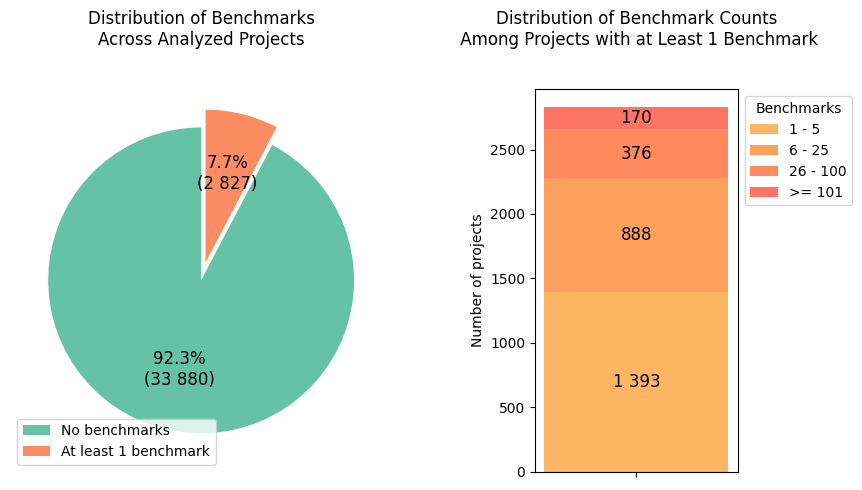

In [60]:
count_zero = (df['BenchmarkData.benchmarkCount'] == 0).sum()
count_non_zero = (df['BenchmarkData.benchmarkCount'] > 0).sum()

data_pie = [count_zero, count_non_zero]
labels_pie = ['No benchmarks', 'At least 1 benchmark']

plt.figure(figsize=(10, 5))

plt.subplot(1, 4, (1, 3))
wedges, texts, autotexts = plt.pie(data_pie, labels=None, autopct=lambda pct: format_autopct(pct, data_pie), startangle=90, textprops={"size": 12, "color": "black"}, explode=[0, 0.12], colors=sns.color_palette('Set2'))
for autotext in autotexts:
    autotext.set
plt.title('Distribution of Benchmarks\nAcross Analyzed Projects', pad=32)
plt.legend(labels_pie)

ax = plt.subplot(1, 4, 4)
non_zero_df = df[df['BenchmarkData.benchmarkCount'] > 0]
counts_non_zero = non_zero_df['BenchmarkData.benchmarkCount'].value_counts()
counts_non_zero = counts_non_zero.sort_index()

f1t5 = counts_non_zero[counts_non_zero.index <= 5].sum()
f6t25 = counts_non_zero[(counts_non_zero.index >= 6) & (counts_non_zero.index <= 25)].sum()
f26t100 = counts_non_zero[(counts_non_zero.index >= 26) & (counts_non_zero.index <= 100)].sum()
f101 = counts_non_zero[(counts_non_zero.index >= 101)].sum()

data_bar = [f1t5, f6t25]
label = ['']

f1t5_bar = plt.bar(label, f1t5, label='1 - 5', color="#fcb562")
plt.bar_label(f1t5_bar, label_type='center', fontsize=12, labels=[f"{f1t5:,}".replace(",", " ")])

f6t25_bar = plt.bar(label, f6t25, bottom=f1t5, label='6 - 25', color="#fea05d")
plt.bar_label(f6t25_bar, label_type='center', fontsize=12, labels=[f"{f6t25:,}".replace(",", " ")])

f26t100_bar = plt.bar(label, f26t100, bottom=f1t5+f6t25, label='26 - 100', color="#ff8a5d")
plt.bar_label(f26t100_bar, label_type='center', fontsize=12, labels=[f"{f26t100:,}".replace(",", " ")])

f101_bar = plt.bar(label, f101, bottom=f1t5+f6t25+f26t100, label='>= 101', color="#fc7462")
plt.bar_label(f101_bar, label_type='center', fontsize=12, labels=[f"{f101:,}".replace(",", " ")])

plt.ylabel('Number of projects')
plt.title('Distribution of Benchmark Counts\n Among Projects with at Least 1 Benchmark', pad=32)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Benchmarks")

plt.tight_layout()
plt.show()

heatmap

/tmp/ipykernel_72486/2534688483.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df_with_benchmarks.groupby(['StarsRange', 'CodeLinesRange'])['BenchmarkData.benchmarkCount'].mean().reset_index()
/tmp/ipykernel_72486/2534688483.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_labels = df_with_benchmarks.groupby(['StarsRange', 'CodeLinesRange'])['BenchmarkData.benchmarkCount'].agg(custom_agg).reset_index().pivot(index='StarsRange', columns='CodeLinesRange', values='BenchmarkData.benchmarkCount')


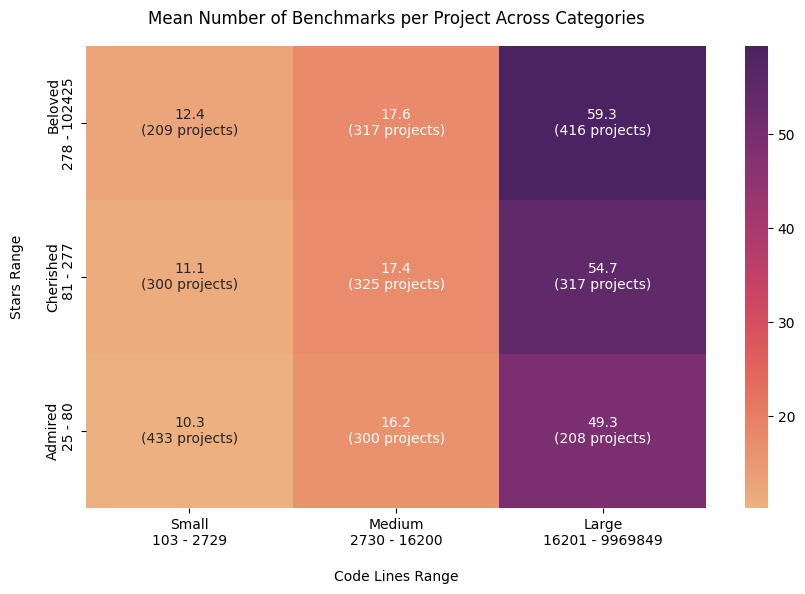

In [61]:
def compute_ranges_elements_count_equal(column_name):
  df_sorted = df_with_benchmarks.sort_values(by=column_name)
  num_elements_per_category = len(df_sorted) // 3
  ranges = [df_sorted[column_name].iloc[0], df_sorted[column_name].iloc[num_elements_per_category], df_sorted[column_name].iloc[2*num_elements_per_category], df_sorted[column_name].iloc[-1]]
  labels = [f"{ranges[i]} - {ranges[i + 1] - 1}" for i in range(len(ranges) - 2)] + [f"{ranges[-2]} - {ranges[-1]}"]
  return ranges, labels

def add_labels_descriptions(labels, descriptions):
  for i in range(len(labels)):
    labels[i] = f"{descriptions[i]}\n{labels[i]}"

stars_ranges, stars_labels = compute_ranges_elements_count_equal('GitRepo.stargazers_count')
code_lines_ranges, code_lines_labels = compute_ranges_elements_count_equal('CodeStatistics.Code')

add_labels_descriptions(stars_labels, ["Admired", "Cherished", "Beloved"])
add_labels_descriptions(code_lines_labels, ["Small", "Medium", "Large"])

df_with_benchmarks['StarsRange'] = pd.cut(df['GitRepo.stargazers_count'], bins=[range for range in stars_ranges], labels=stars_labels, right=False)

df_with_benchmarks['CodeLinesRange'] = pd.cut(df['CodeStatistics.Code'], bins=[range for range in code_lines_ranges], labels=code_lines_labels, right=False)

def custom_agg(values):
  return f"{values.mean():.1f}\n({values.count()} projects)"

heatmap_data = df_with_benchmarks.groupby(['StarsRange', 'CodeLinesRange'])['BenchmarkData.benchmarkCount'].mean().reset_index()
heatmap_labels = df_with_benchmarks.groupby(['StarsRange', 'CodeLinesRange'])['BenchmarkData.benchmarkCount'].agg(custom_agg).reset_index().pivot(index='StarsRange', columns='CodeLinesRange', values='BenchmarkData.benchmarkCount')
# heatmap_data["successfulBenchmarksRatio"] = df_with_benchmarks.groupby(['StarsRange', 'CodeLinesRange']).sum().reset_index().apply(lambda row: row['BenchmarkData.SuccessfulBenchmarkCount'] / row['BenchmarkData.benchmarkCount'], axis=1)

heatmap_pivot = heatmap_data.pivot(index='StarsRange', columns='CodeLinesRange', values='BenchmarkData.benchmarkCount')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_pivot.iloc[::-1], annot=heatmap_labels.iloc[::-1], cmap="flare", fmt="")

plt.title('Mean Number of Benchmarks per Project Across Categories', pad=16)
plt.xlabel('Code Lines Range', labelpad=16)
plt.ylabel('Stars Range', labelpad=16)

plt.show()

/tmp/ipykernel_72486/2098264822.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_labels = df_with_benchmarks.groupby(['StarsRange', 'CodeLinesRange'])[["BenchmarkData.benchmarkCount", 'BenchmarkData.successfulBenchmarkCount']].agg(lambda data: data.mean())
/tmp/ipykernel_72486/2098264822.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  heatmap_labels["ratio"] = heatmap_labels.apply(lambda row: row[1]/row[0], axis=1)
/tmp/ipykernel_72486/2098264822.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

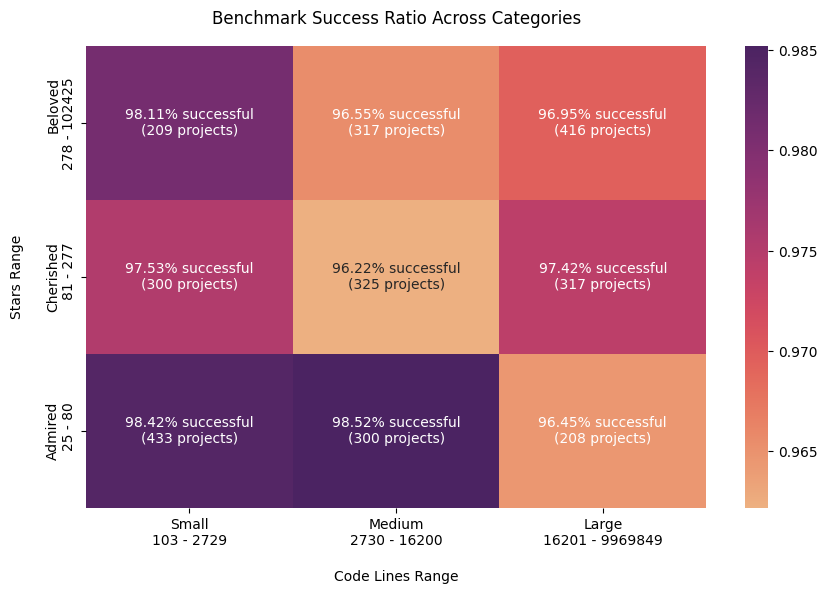

In [62]:
def compute_ranges_elements_count_equal(column_name):
  df_sorted = df_with_benchmarks.sort_values(by=column_name)
  num_elements_per_category = len(df_sorted) // 3
  ranges = [df_sorted[column_name].iloc[0], df_sorted[column_name].iloc[num_elements_per_category], df_sorted[column_name].iloc[2*num_elements_per_category], df_sorted[column_name].iloc[-1]]
  labels = [f"{ranges[i]} - {ranges[i + 1] - 1}" for i in range(len(ranges) - 2)] + [f"{ranges[-2]} - {ranges[-1]}"]
  return ranges, labels

def add_labels_descriptions(labels, descriptions):
  for i in range(len(labels)):
    labels[i] = f"{descriptions[i]}\n{labels[i]}"

stars_ranges, stars_labels = compute_ranges_elements_count_equal('GitRepo.stargazers_count')
code_lines_ranges, code_lines_labels = compute_ranges_elements_count_equal('CodeStatistics.Code')

add_labels_descriptions(stars_labels, ["Admired", "Cherished", "Beloved"])
add_labels_descriptions(code_lines_labels, ["Small", "Medium", "Large"])

df_with_benchmarks['StarsRange'] = pd.cut(df['GitRepo.stargazers_count'], bins=[range for range in stars_ranges], labels=stars_labels, right=False)

df_with_benchmarks['CodeLinesRange'] = pd.cut(df['CodeStatistics.Code'], bins=[range for range in code_lines_ranges], labels=code_lines_labels, right=False)

def set_label(row):
  return f'{row["ratio"] * 100:.2f}% successful\n({row["count"]:.0f} projects)'

heatmap_labels = df_with_benchmarks.groupby(['StarsRange', 'CodeLinesRange'])[["BenchmarkData.benchmarkCount", 'BenchmarkData.successfulBenchmarkCount']].agg(lambda data: data.mean())
heatmap_labels["ratio"] = heatmap_labels.apply(lambda row: row[1]/row[0], axis=1)
heatmap_labels["count"] = df_with_benchmarks.groupby(['StarsRange', 'CodeLinesRange'])["BenchmarkData.benchmarkCount"].count()
heatmap_labels["label"] = heatmap_labels.apply(lambda row: set_label(row), axis=1)

heatmap_pivot = heatmap_labels.reset_index().pivot(index='StarsRange', columns='CodeLinesRange', values='ratio')
heatmap_labels = heatmap_labels.reset_index().pivot(index='StarsRange', columns='CodeLinesRange', values='label')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_pivot.iloc[::-1], annot=heatmap_labels.iloc[::-1], cmap="flare", fmt="")

plt.title('Benchmark Success Ratio Across Categories', pad=16)
plt.xlabel('Code Lines Range', labelpad=16)
plt.ylabel('Stars Range', labelpad=16)

plt.show()

Correlation

In [63]:
correlation_code_benchmarks = df_with_benchmarks['CodeStatistics.Code'].corr(df_with_benchmarks['BenchmarkData.benchmarkCount'])
correlation_stars_benchmarks = df_with_benchmarks['GitRepo.stargazers_count'].corr(df_with_benchmarks['BenchmarkData.benchmarkCount'])

print(f'code-benchmarks correlation: {correlation_code_benchmarks}')
print(f'stars-benchmarks correlation: {correlation_stars_benchmarks}')

code-benchmarks correlation: 0.1580468542596255
stars-benchmarks correlation: 0.05393387071677512


successful & failing benchmarks

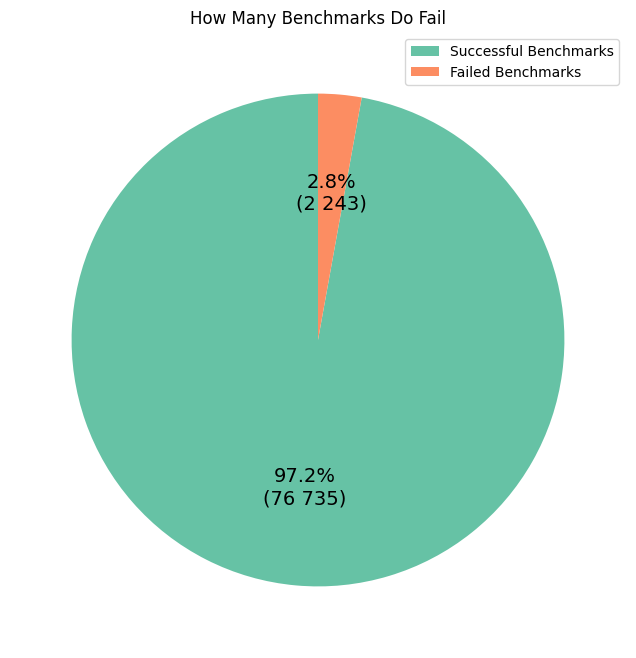

In [64]:
number_of_benchmarks = df_with_benchmarks['BenchmarkData.benchmarkCount'].sum()
successful_benchmarks = df_with_benchmarks['BenchmarkData.successfulBenchmarkCount'].sum()
failed_benchmarks = number_of_benchmarks - successful_benchmarks

labels = ['Successful Benchmarks', 'Failed Benchmarks']
data = [successful_benchmarks, failed_benchmarks]

plt.figure(figsize=(8, 8))
plt.pie(data, labels=None, startangle=90, colors=sns.color_palette('Set2'), autopct=lambda pct: format_autopct(pct, data), textprops={"size": 14})

plt.title("How Many Benchmarks Do Fail")
plt.legend(labels)
plt.show()

pie chart benchmarks days since project birth

In [65]:
benchmarks_df_grouped = benchmarks_df.groupby('daysSinceBirth').count().reset_index()
benchmarks_df_grouped

,daysSinceBirth,daysFromImplementationToModification,modificationsCount,count
0,0,2676,2676,2676
1,1,1539,1539,1539
2,2,986,986,986
3,3,575,575,575
4,4,372,372,372
...,...,...,...,...
2289,4138,4,4,4
2290,4193,8,8,8
2291,4258,3,3,3
2292,4363,1,1,1


In [66]:
benchmarks_df.describe()

,daysSinceBirth,daysFromImplementationToModification,modificationsCount,count
count,60808.000000,60808.000000,60808.000000,60808.0
mean,669.925602,222.995478,1.291721,1.0
std,759.212983,477.322859,2.336657,0.0
min,0.000000,0.000000,0.000000,1.0
25%,76.000000,0.000000,0.000000,1.0
50%,383.000000,0.000000,0.000000,1.0
75%,1052.000000,197.000000,2.000000,1.0
max,4649.000000,3916.000000,50.000000,1.0


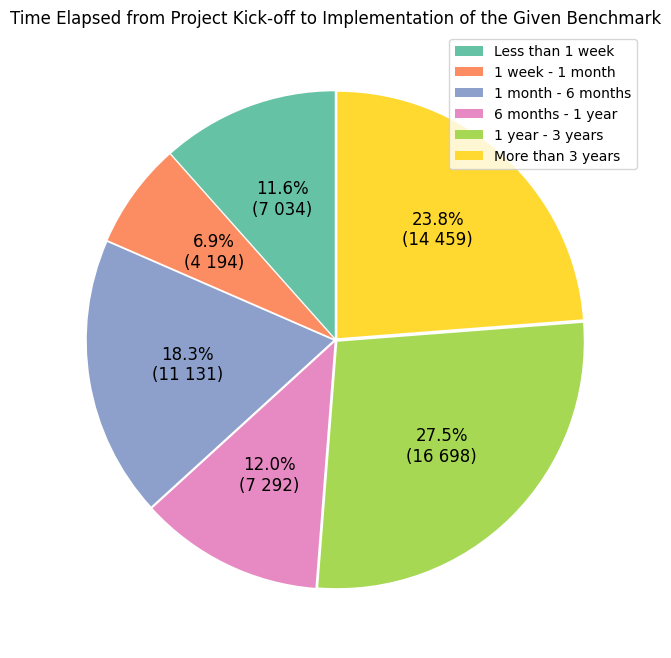

In [67]:
def aggr_func(value):
  suffix = ""
  if value < 8:
    return 'Less than 1 week' + suffix
  if value <= 30:
    return '1 week - 1 month' + suffix
  if value <= 182:
    return '1 month - 6 months' + suffix
  if value <= 365:
    return '6 months - 1 year' + suffix
  if value <= 1095:
    return '1 year - 3 years' + suffix
  return 'More than 3 years' + suffix

benchmarks_df["daysSinceBirthRange"] = benchmarks_df["daysSinceBirth"].apply(aggr_func)
benchmarks_df_grouped = benchmarks_df.groupby("daysSinceBirthRange").count().reset_index()
desired_order = ['Less than 1 week', '1 week - 1 month', '1 month - 6 months', '6 months - 1 year', '1 year - 3 years', 'More than 3 years']
benchmarks_df_grouped['daysSinceBirthRange'] = pd.Categorical(benchmarks_df_grouped['daysSinceBirthRange'], categories=desired_order, ordered=True)
benchmarks_df_grouped = benchmarks_df_grouped.sort_values('daysSinceBirthRange')


plt.figure(figsize=(8, 8))
plt.pie(benchmarks_df_grouped['count'], labels=None, startangle=90, colors=sns.color_palette('Set2'), autopct=lambda pct: format_autopct(pct, benchmarks_df_grouped['count']), textprops={"size": 12}, pctdistance=0.6, explode=[0.01,0.01,0.01,0.01,0.01,0.01])
plt.title('Time Elapsed from Project Kick-off to Implementation of the Given Benchmark')
plt.legend(benchmarks_df_grouped['daysSinceBirthRange'])
plt.show()

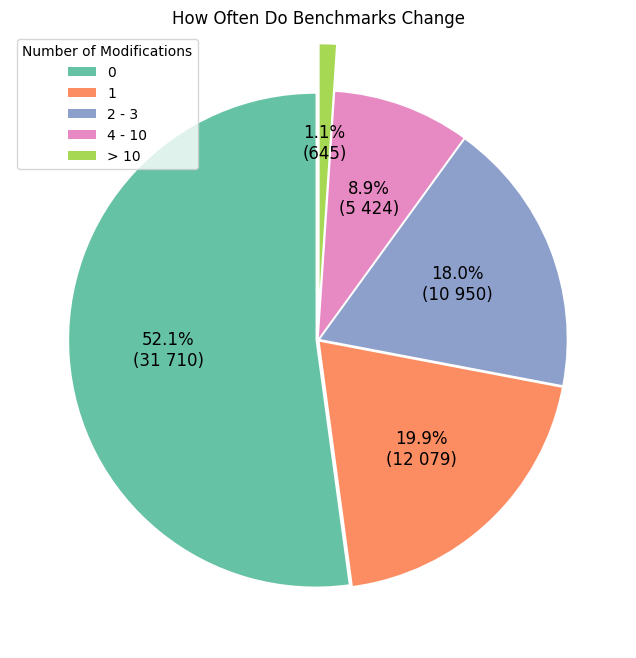

In [68]:
def aggr_func(value):
  suffix = ""
  if value == 0 :
    return '0' + suffix
  if value == 1:
    return '1' + suffix
  if value <= 3:
    return '2 - 3' + suffix
  if value <= 10:
    return '4 - 10' + suffix
  return '> 10' + suffix

benchmarks_df["modificationsCountRange"] = benchmarks_df["modificationsCount"].apply(aggr_func)
benchmarks_df_grouped = benchmarks_df.groupby("modificationsCountRange").count().reset_index()
desired_order = ['0', '1', '2 - 3', '4 - 10', '> 10']
benchmarks_df_grouped['modificationsCountRange'] = pd.Categorical(benchmarks_df_grouped['modificationsCountRange'], categories=desired_order, ordered=True)
benchmarks_df_grouped = benchmarks_df_grouped.sort_values('modificationsCountRange')


plt.figure(figsize=(8, 8))
plt.pie(benchmarks_df_grouped['count'], labels=None, startangle=90, colors=sns.color_palette('Set2'), autopct=lambda pct: format_autopct(pct, benchmarks_df_grouped['count']), textprops={"size": 12}, explode=[0.01, 0.01, 0.01, 0.01, 0.2])
plt.title('How Often Do Benchmarks Change')
plt.legend(benchmarks_df_grouped['modificationsCountRange'], title="Number of Modifications")
plt.show()

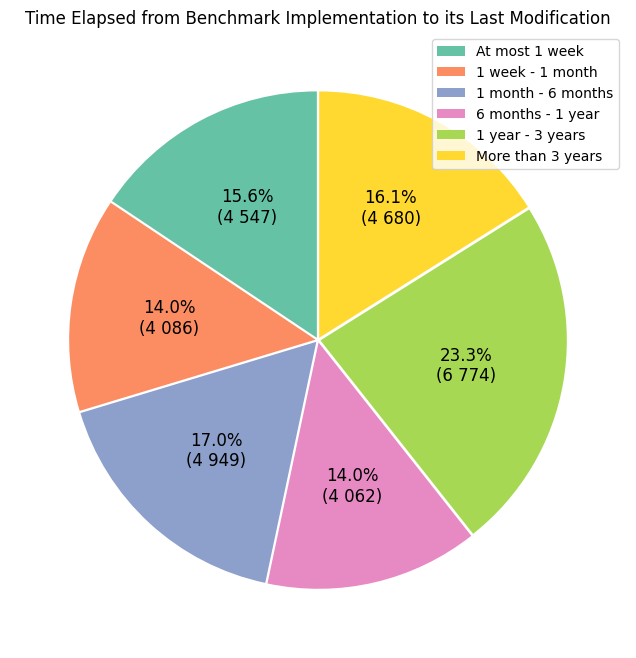

In [69]:
def aggr_func(value):
  suffix = ""
  if value <= 7:
    return 'At most 1 week' + suffix
  if value <= 30:
    return '1 week - 1 month' + suffix
  if value <= 182:
    return '1 month - 6 months' + suffix
  if value <= 365:
    return '6 months - 1 year' + suffix
  if value <= 1095:
    return '1 year - 3 years' + suffix
  return 'More than 3 years' + suffix

benchmarks_df["daysFromImplementationToModificationRange"] = benchmarks_df["daysFromImplementationToModification"].apply(aggr_func)
benchmark_modifications_df = benchmarks_df[benchmarks_df['modificationsCount'] > 0]
benchmarks_df_grouped = benchmark_modifications_df.groupby("daysFromImplementationToModificationRange").count().reset_index()
desired_order = ['At most 1 week', '1 week - 1 month', '1 month - 6 months', '6 months - 1 year', '1 year - 3 years', 'More than 3 years']
benchmarks_df_grouped['daysFromImplementationToModificationRange'] = pd.Categorical(benchmarks_df_grouped['daysFromImplementationToModificationRange'], categories=desired_order, ordered=True)
benchmarks_df_grouped = benchmarks_df_grouped.sort_values('daysFromImplementationToModificationRange')

plt.figure(figsize=(8, 8))
plt.pie(benchmarks_df_grouped['count'], labels=None, startangle=90, colors=sns.color_palette('Set2'), autopct=lambda pct: format_autopct(pct, benchmarks_df_grouped['count']), textprops={"size": 12}, pctdistance=0.6, explode=[0.01,0.01,0.01,0.01,0.01,0.01])
plt.title('Time Elapsed from Benchmark Implementation to its Last Modification')
plt.legend(benchmarks_df_grouped['daysFromImplementationToModificationRange'])
plt.show()